# Chp 7. Prediction
- 발표자 : 이아름
- 발표일 : 2017.9.9(토)

## 7.1 The Boston Bruins problem

2010년 하키 결승전에서, 보스턴 브루인스vs밴쿠버 캐넉스 경기가 있었다.
보스턴은 2게임을 0-1과 2-3으로 지고,
다음 2게임에서는 8-1과 4-0으로 이겼다.

Q. 보스턴이 다음 경기에서 이길확률은 ? 챔피언십에서 우승할 확률은 ?

이 문제에 대답할 때는 몇 가지 가정을 해야 한다.

1. 하키의 골에 대한 점수는 최소한 게임의 어떤 때든 골이 성공할 가능성이 동일하다고 보는 포아송 프로세스(어떤 시간까지 일어날 사건의 개수,독립)를 따른다
2. 특정 상대에 대해서 각 팀의 게임별 장기적 평균 골 수 는 λ 라고 표기 한다.

주어진 가정에 대해 이 질문에 대답하려면, 다음 과정을 거친다.

- λ에 대한 사전 분포를 고르기 위해 전 게임에 대한 통계를 확인한다.
- 각 팀에 대한 λ 추정을 위해 처음 4게임의 점수를 사용한다
- λ의 사후 분포를 통해 각 팀의 골의 분포, 골 차이 분포, 각 팀이 다음에 이길 확률 계산한다
- 각 팀이 이번 시리즈에서 이길 확률을 구한다



가우시안 분포는 연속형 pmf로 추정 : MakeGaussianPmf 사용

In [1]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np

from thinkbayes2 import Pmf, Cdf, Suite, Joint
import thinkplot
import thinkbayes2

In [2]:
def MakeGaussianPmf(mu, sigma, num_sigmas, n=201):
    """Makes a PMF discrete approx to a Gaussian distribution.
    
    mu: float mean
    sigma: float standard deviation
    num_sigmas: how many sigmas to extend in each direction
    n: number of values in the Pmf
    returns: normalized Pmf
    """
    pmf = Pmf()
    low = mu - num_sigmas * sigma
    high = mu + num_sigmas * sigma

    for x in numpy.linspace(low, high, n):
        p = EvalGaussianPdf(x, mu, sigma)
        pmf.Set(x, p)
    pmf.Normalize()
    return pmf

    - mu와 sigma는 가우시안 분포의 평균/표준편차
    - num_sigmas는 pmf 범위의 평균 이상/이하 범위에 속하는 편차의 수
    - n은 pmf의 값의 수

    - numpy.linspace : low 이상 high 이하 범위 값을 n개 동일 구간으로 나눈 값을 배열로 만들기 
    - norm.pdf는 가우시안 확률 밀도 함수(pdf)계산

- 하키문제에서, λ의 값에 대한 가설 suite 정의 (아래와 같음)

In [3]:
class Hockey(thinkbayes2.Suite):
    def __init__(self):
        pmf = thinkbayes.MakeGaussianPmf(2.7, 0.3, 4)
        thinkbayes2.Suite.__init__(self, pmf)

    - 사전 분포는 평균 2.7에 표준편차가 0.3인 가우시안 분포를 따르고,
    - 평균 상하로 4 시그마씩의 범위를 갖는다
    
    
## 7.2 Poisson processes

- 프로세스 : 물리 시스템에 대한 모델
- 베르누이 프로세스 : 'trials'라는 사건의 나열로 이루어진 모델. 이때 trial은 성공/실패 2가지로 나옴
  따라서 베르누이 프로세스는 연속적으로 동전 던지기나 골에 공을 넣는 것에 대한 자연적 모델임
  
- poisson 프로세스 : 베르누이 프로세스의 연속형으로 사건이 어떤 시점에서든 동일한 확률로 발생할 수 있는 형태

  ex) 가게에 손님이 도착하는 것, 버스 정류장에 버스가 도착하는 것, 하키게임에서 골이 성공하는 것
  
  실제로 사건 확률은 시간에 따라 변한다. 손님들이 특정시간에 가게 방문하는 것, 버스도 주기로 도착하도록 되어있고, 골은 게임동안 시간마다 들어갈 확률이 달라짐
  
- 하키게임은 poisson 프로세스로 모델링 해보자.

    - 이 모델을 사용하면 효율적으로 게임당 골 수의 분포를 계산할 수 있을 뿐더러, 골 간의 시간 분포에 대해서도 알 수 있음
    
       ex) 게임당 평균 골 수가 1am이라면, 게임당 골 분포 : poisson pmf 로 주어짐




In [4]:
def EvalPoissonPmf(k, lam):
    """Computes the Poisson PMF.
    k: number of events
    lam: parameter lambda in events per unit time
    returns: float probability
    """
    return scipy.stats.poisson.pmf(k, lam)

    - 골 간의 시간 분포는 지수 PDF를 따른다 

In [5]:
def EvalExponentialPdf(x, lam):
    """Computes the exponential PDF.
    x: value
    lam: parameter lambda in events per unit time
    returns: float probability density
    """
    return lam * math.exp(-lam * x)

## 7.3 사후분포

- 게임에서 k골을 넣었을 때의 점수 lam의 가설 값을 갖는 우도 계산하기

In [6]:
from thinkbayes2 import MakeNormalPmf
from thinkbayes2 import EvalPoissonPmf

class Hockey(Suite):
    """Represents hypotheses about the scoring rate for a team."""

    def __init__(self, label=None):
        """Initializes the Hockey object.

        label: string
        """
        mu = 2.8
        sigma = 0.3

        pmf = MakeNormalPmf(mu, sigma, num_sigmas=4, n=101)
        Suite.__init__(self, pmf, label=label)
            
    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        Evaluates the Poisson PMF for lambda and k.

        hypo: goal scoring rate in goals per game
        data: goals scored in one game
        """
        lam = hypo
        k = data
        like = EvalPoissonPmf(k, lam)
        return like

    - 각 가설 hypo는 λ에 대한 값
    - data는 관측된 골의 개수
    
    - 우도 함수 사용해서 , 각 팀의 suite 만들고, 처음 4경기의 점수를 사용해서 update 하기

In [7]:
suite1 = Hockey('bruins')
suite2 = Hockey('canucks')

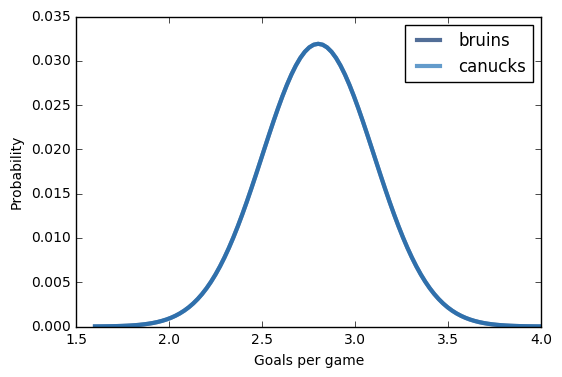

In [8]:
thinkplot.PrePlot(num=2)
thinkplot.Pdf(suite1)
thinkplot.Pdf(suite2)
thinkplot.Config(xlabel='Goals per game',
                ylabel='Probability')

(2.8814477910015488, 2.6145205761109493)

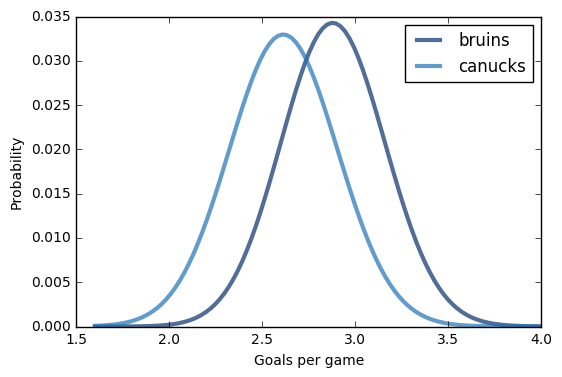

In [9]:
suite1.UpdateSet([0, 2, 8, 4])
suite2.UpdateSet([1, 3, 1, 0])

thinkplot.PrePlot(num=2)
thinkplot.Pdf(suite1)
thinkplot.Pdf(suite2)
thinkplot.Config(xlabel='Goals per game',
                ylabel='Probability')

suite1.Mean(), suite2.Mean()

    - lam의 사후 분포 
    - lam의 근사값 , canucks : 2.6   bruins : 2.9

            
## 골의 분포

각 팀이 다음 경기에서 이길 확률을 계산하려면, 각 팀의 골의 분포를 계산해야 함.

만약, 우리가 lam 값을 정확히 알고 있다면 poisson 분포를 다시 사용할 수 있다

    - MakePoissonPmf 사용


In [10]:
from thinkbayes2 import MakePoissonPmf

def MakePoissonPmf(lam, high):
    pmf = Pmf()
    for k in range(0, high+1):
        p = EvalPoissonPmf(k, lam)
        pmf.Set(k, p)
    pmf.Normalize()
    return pmf

    - 구해진 pmf 범위는 0부터 high 까지. 
    - 따라서, lam 값이 정확히 3.4라면 아래와 같이 계산 가능

In [11]:
lam =3.4
goal_dist = thinkbayes2.MakePoissonPmf(lam,10)

- 한 게임에서 10골 이상 나올 가능성은 매우 낮기때문에 여기서는 최댓값을 10으로 설정
    - lam 의 값은 정확하게 모르고, 대신 lam의 주어진 사후 분포에 대해, 골의 분포를 생성할 수 있음
        - lam의 값에 대해, 골의 분포는 poisson 분포를 따른다.
        - 따라서 골 전체 분포는 poisson 분포의 혼합형으로 lam의 분포 확률에 따라 가중치가 주어진다.

In [12]:
from thinkbayes2 import MakeMixture
from thinkbayes2 import MakePoissonPmf

def MakeGoalPmf(suite, high=10):
    """Makes the distribution of goals scored, given distribution of lam.

    suite: distribution of goal-scoring rate
    high: upper bound

    returns: Pmf of goals per game
    """
    metapmf = Pmf()

    for lam, prob in suite.Items():
        pmf = MakePoissonPmf(lam, high)
        metapmf.Set(pmf, prob)

    mix = MakeMixture(metapmf, label=suite.label)
    return mix

    - lam 값에 대해 poison Pmf를 만들고 이를 metapmf에 더함
    - 혼합분포값 계산을 위해 MakeMixture를 사용

(2.8792178420902266, 2.6134252104851332)

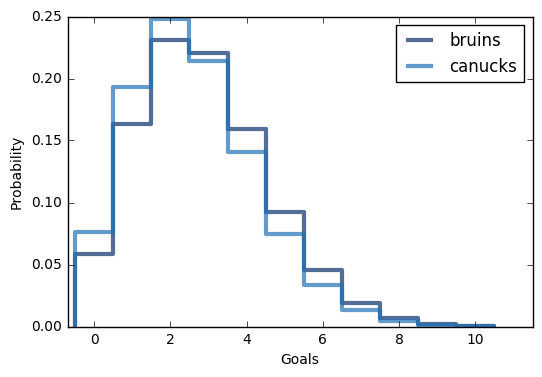

In [13]:
goal_dist1 = MakeGoalPmf(suite1)
goal_dist2 = MakeGoalPmf(suite2)

thinkplot.PrePlot(num=2)
thinkplot.Pmf(goal_dist1)
thinkplot.Pmf(goal_dist2)
thinkplot.Config(xlabel='Goals',
                ylabel='Probability',
                xlim=[-0.7, 11.5])

goal_dist1.Mean(), goal_dist2.Mean()

# 단일 게임에서의 골의 분포

## 7.5 이길 확률

- 이길 확률 구하기 위해서는, 골 수 차이의 분포를 계산해야 한다

    - 골의 차이가 +이면 bruins 가 이김,  차이가 -이면 canucks가 이김,, 0이면 비김

In [14]:
diff = goal_dist1 - goal_dist2
p_win = diff.ProbGreater(0)
p_loss = diff.ProbLess(0)
p_tie = diff.Prob(0)

print('Prob win, loss, tie:', p_win, p_loss, p_tie)

Prob win, loss, tie: 0.457999782312 0.370290326041 0.171709891647


## 7.6 sudden death

- sudden death : 동점으로 끝날 겨우, 한 팀이 이길 때까지 정규 시간 이후에도 경기를 진행함.
    - 첫번째 골이 들어가는 순간 게임은 끝나고, 이런 시간외 경기를 sudden death라고 한다.
    
    
- 시간 외의 서든 데스에서 이길 확률을 계산하기 위해서, 중요한 통계는 처음 골 넣기까지 걸리는 시간.

- 주어진 lam에 대해 다음과 같이 골 간의 시간 계산

    -high 는 분포의 상한값. 점수가 안나온 채 2게임 이상 진행될 확률은 적으므로 2
    
    -n은 pmf 값의 개수
    
    -lam의 값은 모르기 때문에, 사후 분포 갖고 있음. 골의 분포를 구해서 meta-pmf구하고, pmf의 혼합값을 계산

In [15]:
from thinkbayes2 import MakeExponentialPmf

def MakeGoalTimePmf(suite):
    """Makes the distribution of time til first goal.

    suite: distribution of goal-scoring rate

    returns: Pmf of goals per game
    """
    metapmf = Pmf()

    for lam, prob in suite.Items():
        pmf = MakeExponentialPmf(lam, high=2, n=2001)
        metapmf.Set(pmf, prob)

    mix = MakeMixture(metapmf, label=suite.label)
    return mix

- 시간 값이 게임의 1/3보다짧을경우, bruins 가 먼저 득점할 가능성이 높다.
- 2팀이 동시에 점수 내기는 불가능하기에 


- 골 time이 bruins가 더 짧으므로, 이길 확률이 높다

(0.34253098902277268, 0.37409601430770112)

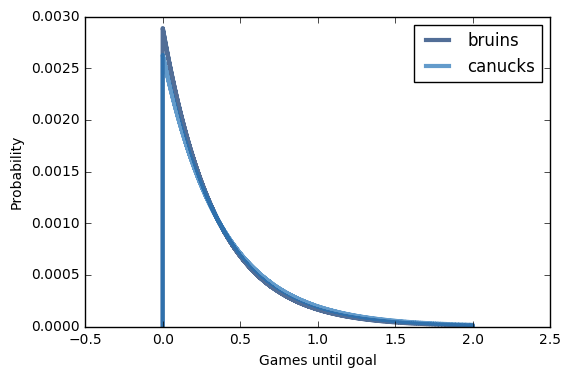

In [16]:
time_dist1 = MakeGoalTimePmf(suite1)     # bruins
time_dist2 = MakeGoalTimePmf(suite2)     # canucks
 
thinkplot.PrePlot(num=2)
thinkplot.Pmf(time_dist1)
thinkplot.Pmf(time_dist2)    
thinkplot.Config(xlabel='Games until goal',
                   ylabel='Probability')

time_dist1.Mean(), time_dist2.Mean()


In [17]:
p_win_in_overtime = time_dist1.ProbLess(time_dist2)
p_adjust = time_dist1.ProbEqual(time_dist2)
p_win_in_overtime += p_adjust / 2
print('p_win_in_overtime', p_win_in_overtime)

p_win_in_overtime 0.523473074433


- bruins가 본 경기 후 이길 확률은 52%

- 마지막으로 이길 확률 계산은, 정규 경기 이길확률 + 경기 후 이길확률

    - 54%

In [18]:
p_win_overall = p_win + p_tie * p_win_in_overtime
print('p_win_overall', p_win_overall)

p_win_overall 0.547885287203


- 이 시리즈에서 이기려면 bruins는 다음 2게임을 이기거나, 다음 2게임까지 승점이 동일하고 3번째 게임에서 이겨야 한다.



In [19]:
# 다음 2경기에서 이길 확률
p_series = p_win**2

print (p_series)
# 다음 2경기에서 승점이 동일하고, 3번째 게임에서 이길 확률

p_series += 2 * p_win * (1-p_win) * p_win


print (p_series)

0.209763800598
0.437147851772


- bruins가 시리즈에서 이길 확률은 57% 이다.